In [1]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

# Equivariant library
import e2cnn
from e2cnn import gspaces

# Notebook dependencies
from IPython.display import clear_output, Image

from utils import *

import importlib
import sys

# importlib.reload(sys.modules['utils'])
# from utils import *

device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:0


In [3]:
device_id2 = 1
device2 = torch.device(f'cuda:{device_id2}' if torch.cuda.is_available() else 'cpu')
print('device2 is {}'.format(device2))

device2 is cuda:1


In [4]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

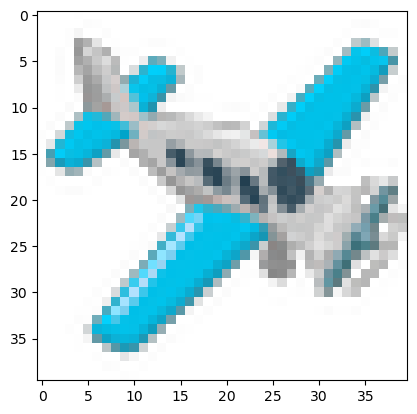

In [5]:
plt.imshow(target_img)
plt.show()

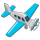

In [6]:
imshow(target_img)

In [7]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, hidden_size=128, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    # Construct learnable perception filters - instead of building a 48 long vector though, directly blow up convolution to hidden size
    # perceive_conv = nn.Conv2d(in_channels=self.channel_n, out_channels=hidden_size, kernel_size=3, padding='same', groups=self.channel_n)
    
    # Equivariant Perception
    r2_act = gspaces.Rot2dOnR2(N=4)
    in_type = e2cnn.nn.FieldType(r2_act, CHANNEL_N*[r2_act.trivial_repr])
    out_type = e2cnn.nn.FieldType(r2_act, 48*[r2_act.regular_repr]) # 32*4=128 is hidden size
    # out_type = e2cnn.nn.FieldType(r2_act, 32*[r2_act.trivial_repr]) # 32*4=128 is hidden size
    equivariant_perception = e2cnn.nn.R2Conv(in_type, out_type, kernel_size=3, \
                               padding=(1,1), groups=CHANNEL_N)
    
    self.gpool = e2cnn.nn.GroupPooling(out_type)

    conv1 = nn.Conv2d(in_channels=48, out_channels=hidden_size, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    # torch.nn.init.zeros_(perceive_conv.bias)
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.input_type = in_type
    self.perceive = e2cnn.nn.SequentialModule(
        equivariant_perception,
        # e2cnn.nn.ReLU(out_type)
    )
    
    # self.perceive = nn.Sequential(
    #     perceive_conv,
    #     nn.ReLU(),
    # )

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    # Geometric version
    geometric_x = e2cnn.nn.GeometricTensor(x, self.input_type)
    y = self.perceive(geometric_x)
    
    # Pool over the group
    y = self.gpool(y).tensor
    
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

print(CAModel().perceive)
print(CAModel().dmodel)

SequentialModule(
  (0): R2Conv([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=3, stride=1, padding=(1, 1), groups=16)
)
Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)


/u/sradev/anaconda3/envs/caproject/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


shape of permuted seed: torch.Size([16, 72, 72])


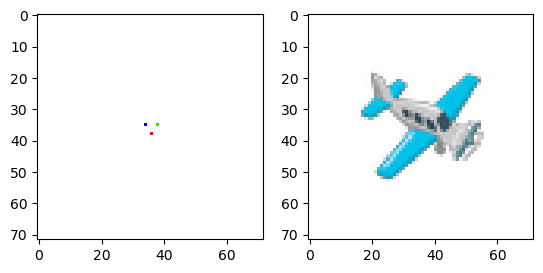

In [8]:
# I love chatGPT
def get_circle_points(a, b, radius, num_points=3):
    """Returns three non-collinear points on a circle, centered
        at (a, b) with radius `radius`."""
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = a + radius * math.cos(angle)
        y = b + radius * math.sin(angle)
        points.append((int(round(x)), int(round(y))))
    return points

def make_seed(target_img, radius=None, rot=0, p=TARGET_PADDING, device=device, print_seed=True):
    """Makes an asymmetric seed with three non-collinear points.
        If radius is None, seeds a single pixel.
        `rot` is an int in [1,2,3,4], representing 90 degree
        rotations to the left."""
    target_img = torch.tensor(target_img)
    pad_target = torch.nn.functional.pad(target_img, (0, 0, p, p, p, p))
    h, w = pad_target.shape[:2] # get height and width of padded target image
    x, y = h//2, w//2 # get coordinates of center pixel
    seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
    if radius is None:
        seed[x, y, 3:] = 1.0    
        return seed

    # Rotate the points
    points = get_circle_points(x, y, radius)
    points = [points[(i+rot) % len(points)] for i in range(len(points))]

    # Seed the points
    for color_channel_i, point in enumerate(points):
        seed[point[0], point[1], 3:] = 1.0  # set auxiliary channels
        seed[point[0], point[1], color_channel_i] = 1.0  # set color channel
        
    if print_seed:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        permuted_seed = seed.permute(-1, 0, 1)
        print(f'shape of permuted seed: {permuted_seed.shape}')
        ax1.imshow(seed[..., :4])
        ax2.imshow(pad_target)
        # ax2.imshow(permuted_seed[:4, ...])
        fig.show()
        
    return seed.to(device), pad_target.to(device)
        
seed, pad_target = make_seed(target_img, radius=2)

In [9]:
h, w = pad_target.shape[:2] # get height and width of padded target image
x, y = h//2, w//2 # get coordinates of center pixel

points = get_circle_points(x, y, 2)
print(points)
points = [points[(i+2) % len(points)] for i in range(len(points))]
print(points)

[(38, 36), (35, 38), (35, 34)]
[(35, 34), (38, 36), (35, 38)]


In [10]:
def rotate_seed(seed, rotation):
    """`seed` is a 3-dimensional seed of shape (H, W, C).
        `rotation` is an int in [1,2,3,4], representing 90 degree
        rotations to the left.
    """
    

In [11]:
def plot_tensor(tensor):
    """plt.imshow a geometric tensor"""
    # Convert to PyTorch tensor
    try:
        tensor = tensor.tensor
    except AttributeError:
        plt.imshow(tensor.detach().cpu()[..., :4])
        plt.show() 
        return
    
    # Reshape to matplotlib convention
    tensor = tensor.detach().cpu() # detach tensor
    if len(tensor.shape) == 3:
        permuted_tensor = tensor.permute(1, 2, 0)
    elif len(tensor.shape) == 4:
        permuted_tensor = tensor.permute(0, 2, 3, 1)[0, ...]
    else:
        raise ValueError("geometric_tensor is not 3 or 4 dimensions")
    plt.imshow(permuted_tensor[..., :4])
    plt.show()

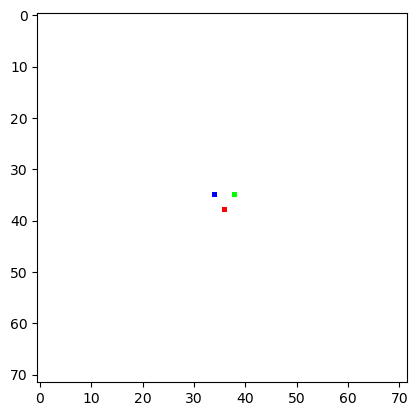

In [12]:
seed.shape
plot_tensor(seed)

In [15]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr, weight_decay=1e-8)
    # self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)
    # Use library MSELoss
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, x0, n_steps=1001):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        clear_output()

        # visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # plot loss
        plot_loss(self.loss_log)
        # export model

      print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    loss = self.loss_f(to_rgba(x), self.target)
    # loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Update parameters
    self.optim.step()
    
    # Update learning rate step
    # self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


batch (before/after):


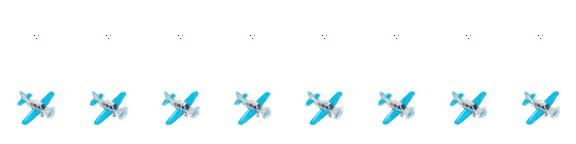

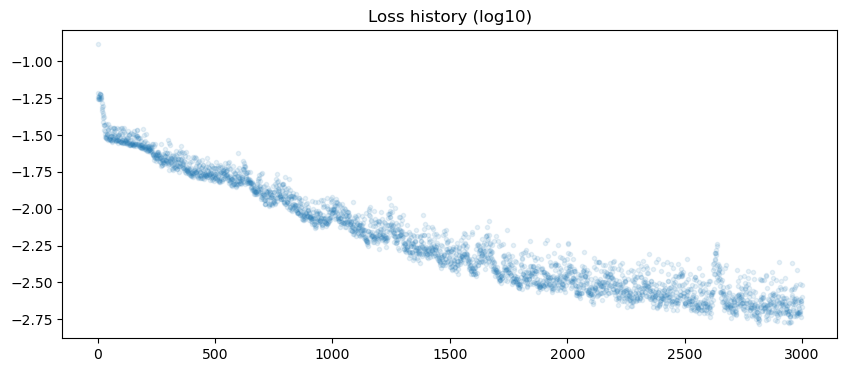

 step: 3001, log10(loss): -2.654CPU times: user 20min 32s, sys: 13.8 s, total: 20min 46s
Wall time: 23min 23s


In [16]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=3001)

In [39]:
save_ca_model(ca, "e2cnn_model_2_4001")

Saved model e2cnn_model_2_4001 to disk


batch (before/after):


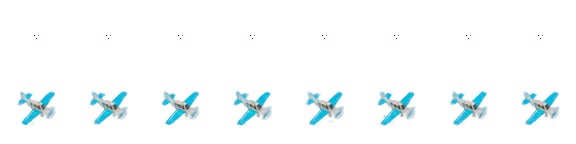

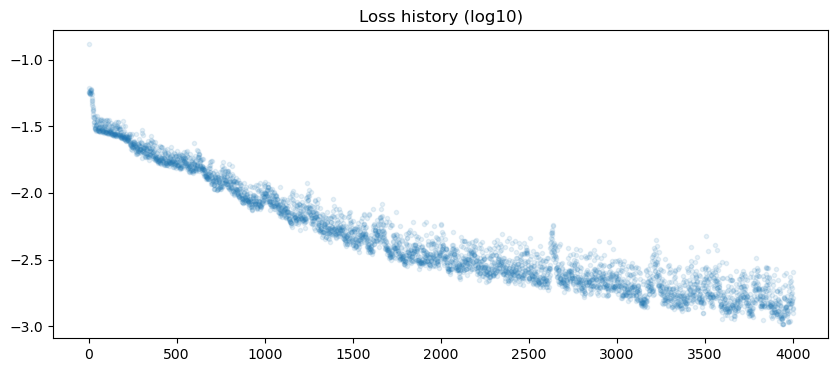

 step: 1001, log10(loss): -2.788

In [34]:
loss_log += train.train(x0.to(device), n_steps = 1001) # Start training at step 3001

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


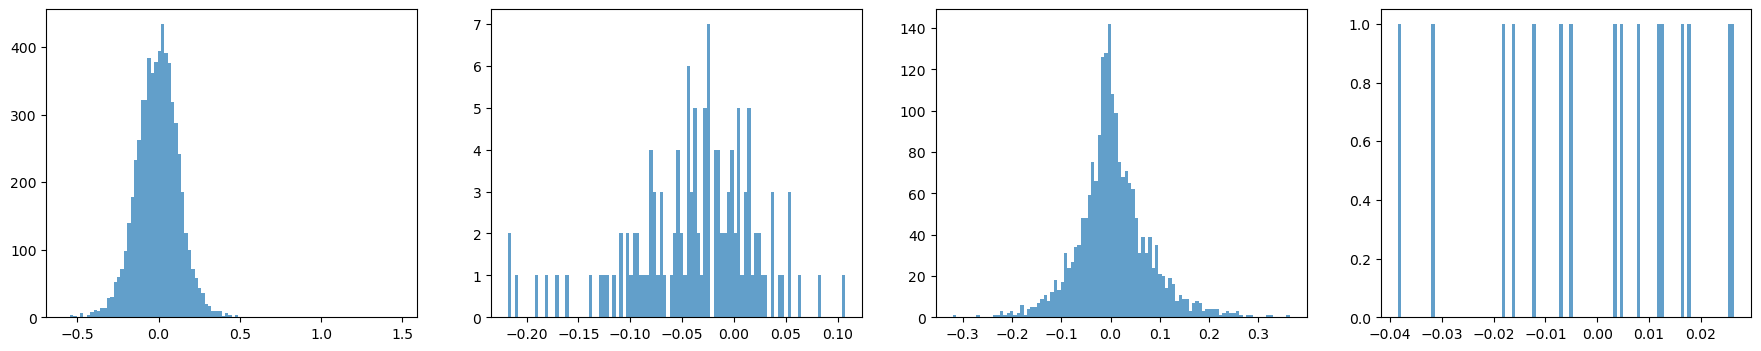

In [38]:
show_weights(ca)

batch (before/after):


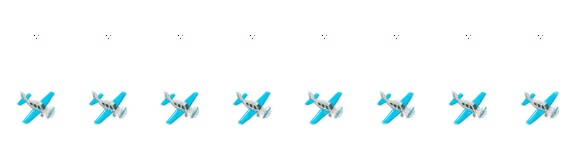

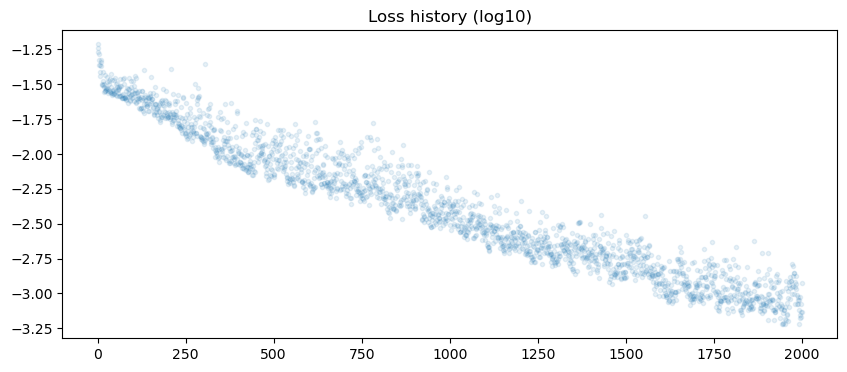

 step: 2001, log10(loss): -2.981CPU times: user 8min 12s, sys: 9.93 s, total: 8min 22s
Wall time: 7min 19s


In [159]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=2001)

In [18]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
# ca = load_ca_model(CAModel, "e2cnn_model_1", device=device)

batch (before/after):


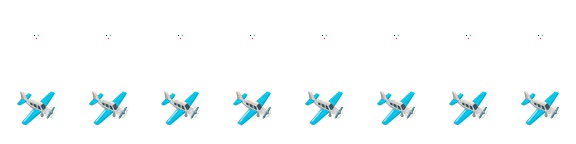

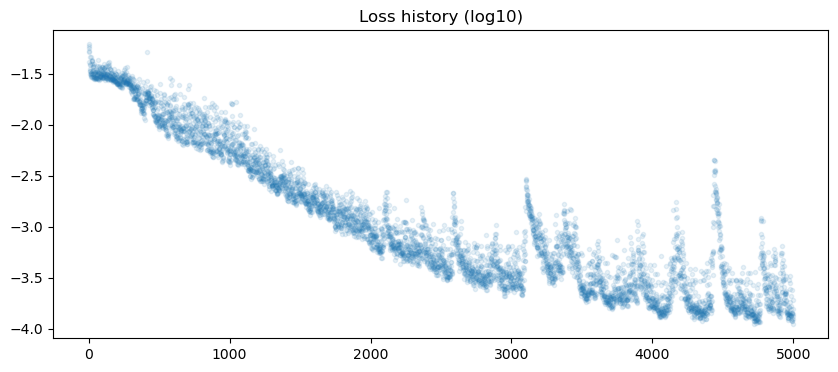

 step: 5001, log10(loss): -3.935CPU times: user 18min 31s, sys: 32.3 s, total: 19min 4s
Wall time: 16min 34s


In [16]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=5001)

batch (before/after):


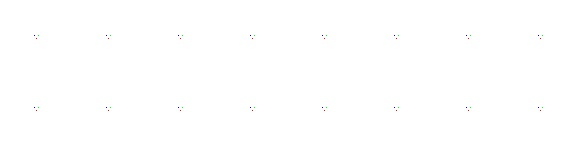

In [40]:
visualize_batch(x0.detach().cpu(), x0.detach().cpu(), None)

shape of permuted seed: torch.Size([16, 72, 72])


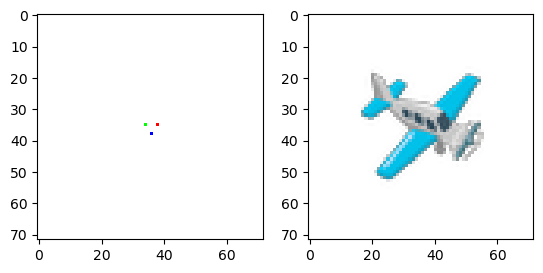

In [41]:
rotated_seed, _ = make_seed(target_img, radius=2, rot=1)

torch.Size([1, 16, 72, 72])
torch.Size([1, 72, 72, 16])


100%|███████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 468.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


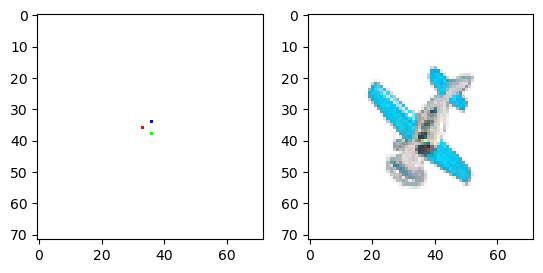

In [35]:
# Copy from inside model
r2_act = gspaces.Rot2dOnR2(N=4)
in_type = e2cnn.nn.FieldType(r2_act, CHANNEL_N*[r2_act.trivial_repr])
input_x = seed.unsqueeze(0)
geometric_x0 = e2cnn.nn.GeometricTensor(input_x.permute(0, -1, 1, 2), in_type)
print(geometric_x0.tensor.shape)

rotated_seed = geometric_x0.transform(3).tensor.permute(0, 2, 3, 1)
print(rotated_seed.shape)
simulate_model(ca, rotated_seed, n_steps=90, device=device)

100%|███████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 475.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


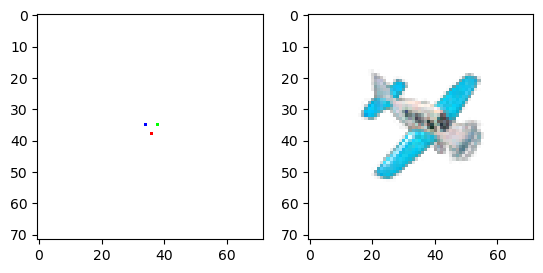

In [37]:
simulate_model(ca, seed.unsqueeze(0), n_steps=90, device=device)

In [32]:
params = ca.named_parameters()
for name, p in params:
    # print(name)
    # if 'perceive' in name:
        # print(p.data)
    print(name)
    print(p.shape)

perceive.0.weight
torch.Size([128, 16, 3, 3])
perceive.0.bias
torch.Size([128])
dmodel.0.weight
torch.Size([128, 128, 1, 1])
dmodel.0.bias
torch.Size([128])
dmodel.2.weight
torch.Size([16, 128, 1, 1])
dmodel.2.bias
torch.Size([16])


In [26]:
ca_copy = ca
params = ca_copy.named_parameters()
for name, p in params:
    # print(name)
    # if 'perceive' in name:
    print(name)
    print(p.shape)

perceive.0.weight
torch.Size([128, 16, 3, 3])
perceive.0.bias
torch.Size([128])
dmodel.0.weight
torch.Size([128, 128, 1, 1])
dmodel.0.bias
torch.Size([128])
dmodel.2.weight
torch.Size([16, 128, 1, 1])
dmodel.2.bias
torch.Size([16])


In [11]:
test_load = load_ca_model(CAModel, "vanilla_ca")

100%|██████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 37.31it/s]

y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y shape: torch.Size([1, 48, 72, 72])
y

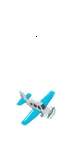

In [12]:
simulate_model(test_load, seed.unsqueeze(0), 80, device=device)

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


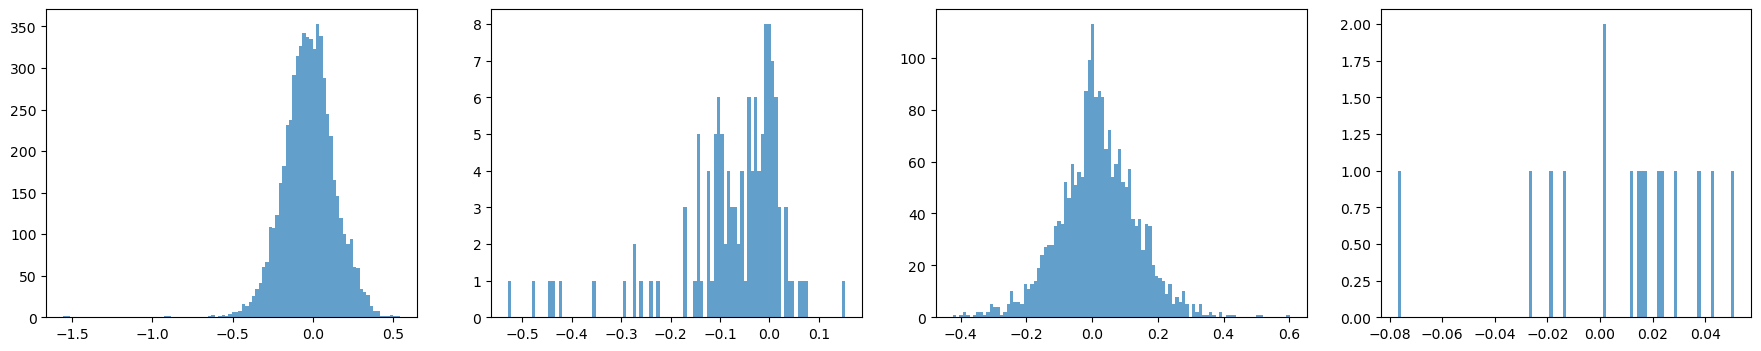

In [50]:
show_weights(test_load)

batch (before/after):


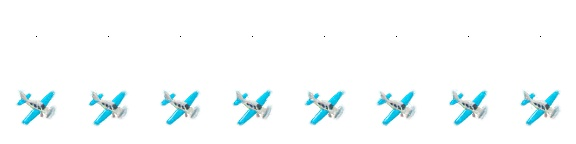

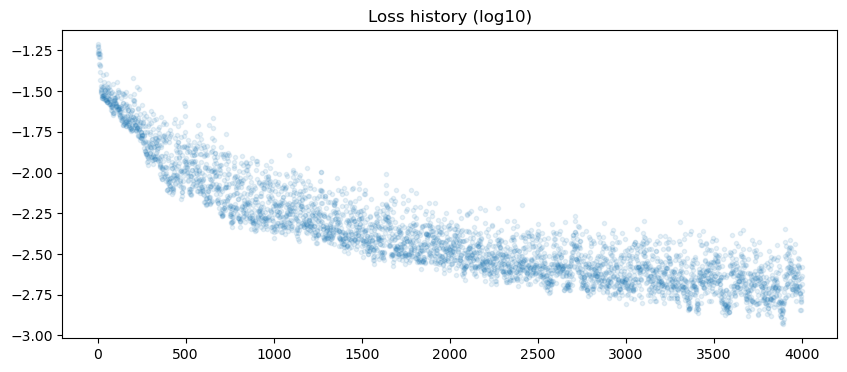

 step: 4001, log10(loss): -2.625CPU times: user 10min 43s, sys: 7.16 s, total: 10min 51s
Wall time: 8min 48s


In [170]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

In [174]:
save_ca_model(ca, "vanilla_ca_4")

Saved model vanilla_ca_4 to disk


In [171]:
test_load = load_ca_model(CAModel, "vanilla_ca_3", device=device)

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


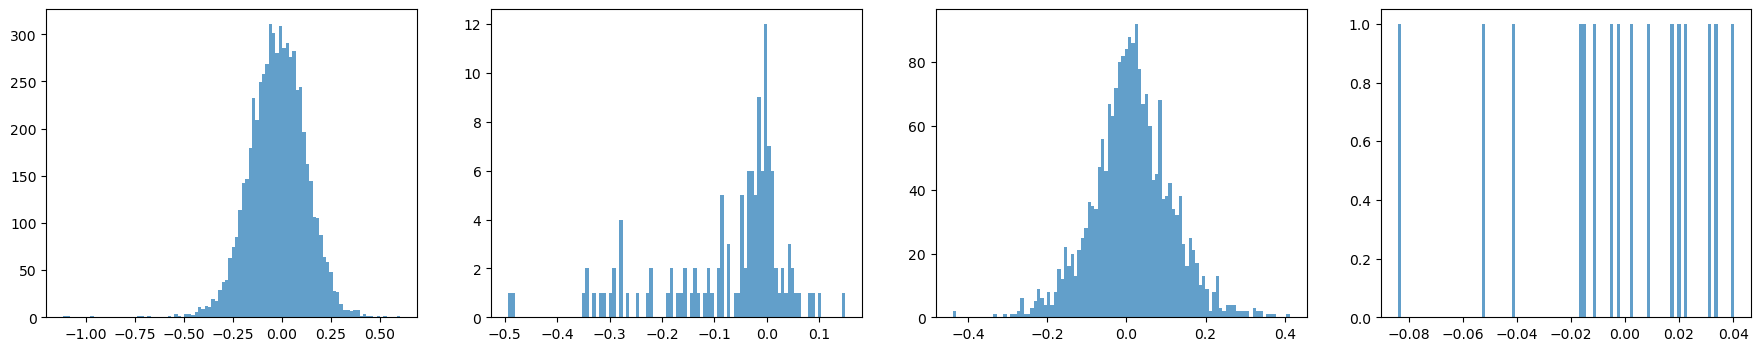

In [172]:
show_weights(ca)

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


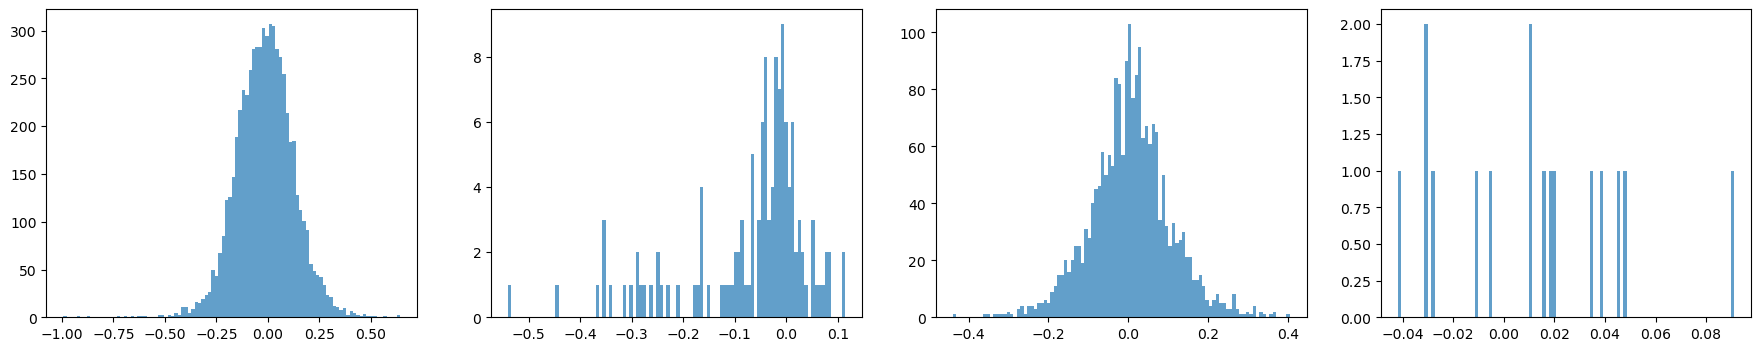

In [173]:
show_weights(test_load)

In [175]:
def compare_model_weights(model1, model2):
    pdist = torch.nn.PairwiseDistance()
    cos = torch.nn.CosineSimilarity(dim=0)

    weights = []
    biases = []

    pdists = {}
    cos_dists = {}
    with torch.no_grad():
        index = 0
        for m1, m2 in zip(model1.modules(), model2.modules()):
            if isinstance(m1, nn.Conv2d) and isinstance(m2, nn.Conv2d):
                index += 1
                # print('inside')
                weight1 = m1.state_dict()['weight'].squeeze()
                bias1 = m1.state_dict()['bias']
                weight2 = m2.state_dict()['weight'].squeeze()
                bias2 = m2.state_dict()['bias']

                print(f'weight1 shape is {weight1.shape} and weight2 shape is {weight2.shape}')
                
                pdists[f'weight{index}'] = pdist(weight1, weight2)
                cos_dists[f'weight{index}'] = cos(weight1, weight2)
                cos_dists[f'bias{index}'] = cos(bias1, bias2)
              
                # weights.append(weight)
                # biases.append(bias)

    return pdists, cos_dists

100%|███████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 495.85it/s]

batch (before/after):


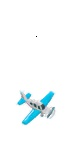

In [156]:
simulate_model(test_load, seed.unsqueeze(0), 80, device=device)